# Weather Data Exploratory Data Analysis

This notebook performs a comprehensive exploratory data analysis on weather data to understand patterns and relationships that might help predict rainfall.

**Objectives:**
- Understand data distribution and completeness
- Identify key features correlated with rain prediction
- Analyze seasonal patterns and time-based trends
- Examine feature interactions and interdependencies
- Discover potential predictors for rain forecasting

**Dataset:** Weather measurements with target variable 'rain_or_not' (binary)

## 1. Setup and Data Loading

Import the necessary libraries and load the preprocessed data.

In [ ]:
# Import essential libraries for data analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
from sklearn.feature_selection import mutual_info_classif
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import calendar
from scipy.stats import chi2_contingency

import warnings
warnings.filterwarnings('ignore')


# Set visualization style
#plt.style.use('seaborn-whitegrid')

sns.set_palette('viridis')
sns.set_context("notebook", font_scale=1.2)

# Create output directory for plots
output_dir = 'eda_plots'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Created output directory: {output_dir}")
else:
    print(f"Output directory already exists: {output_dir}")

Output directory already exists: eda_plots


In [ ]:

# try:
# Try to load preprocessed data first
df_train = pd.read_csv(r'../Data-Set/processed_data/final/weather_train_with_dates.csv', parse_dates=['date'])
df_test = pd.read_csv(r'../Data-Set/processed_data/final/weather_test_with_dates_realigned.csv', parse_dates=['date'])

"""
    
#     # Check that essential columns exist
#     required_cols = ['date', 'rain_or_not']
#     if not all(col in df_train.columns for col in required_cols):
#         raise ValueError("Preprocessed training data is missing required columns")
#     if not all(col in df_test.columns for col in required_cols):
#         raise ValueError("Preprocessed test data is missing required columns")
    
#     # Combine for comprehensive analysis"

"""
df = pd.concat([df_train, df_test]).reset_index(drop=True)
print(f"Loaded preprocessed datasets: {len(df)} total samples")

"""
# except (FileNotFoundError, ValueError) as e:
#     # Fall back to original data if preprocessed files don't exist or have issues
#     print(f"Error with preprocessed data: {e}")
#     try:
#         df = pd.read_csv('weather_data.csv', parse_dates=['date'])
#         print(f"Loaded original dataset: {len(df)} samples")
#     except FileNotFoundError:
#         print("Neither preprocessed nor original data found. Please check file paths.")
#         # Create a small sample dataset to demonstrate code functionality
#         df = pd.DataFrame({'date': pd.date_range(start='2020-01-01', periods=100),
#                           'avg_temperature': np.random.normal(20, 5, 100),
#                           'humidity': np.random.normal(70, 10, 100),
#                           'avg_wind_speed': np.random.normal(10, 3, 100),
#                           'rain_or_not': np.random.binomial(1, 0.3, 100)})
#         print("Created sample dataset for demonstration purposes.")

# # Verify that rain_or_not is binary
# unique_values = df['rain_or_not'].unique()
# if not set(unique_values).issubset({0, 1}):
#     print(f"Warning: 'rain_or_not' contains non-binary values: {unique_values}")"

"""

Loaded preprocessed datasets: 311 total samples


## 2. Dataset Overview

Let's examine the basic characteristics of our dataset including time range, feature counts, and data completeness.

In [5]:
# Dataset overview and summary statistics
print("=== DATASET OVERVIEW ===")
print(f"Time period: {df['date'].min()} to {df['date'].max()}")
print(f"Number of observations: {len(df)}")
print(f"Number of features: {df.shape[1]}")

# Target variable distribution
rain_count = df['rain_or_not'].sum()
no_rain_count = len(df) - rain_count
rain_pct = rain_count / len(df) * 100

print(f"\nTarget distribution:")
print(f"  - Rain days: {rain_count} ({rain_pct:.2f}%)")
print(f"  - No rain days: {no_rain_count} ({100-rain_pct:.2f}%)")

# Summary statistics
print("\n=== SUMMARY STATISTICS ===") 
display(df.describe().T)

# Check data completeness
print("\n=== DATA COMPLETENESS ===")
missing_values = df.isnull().sum().sort_values(ascending=False)
missing_pct = (missing_values / len(df) * 100).round(2)
completeness_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Missing (%)': missing_pct,
    'Complete (%)': 100 - missing_pct
})
display(completeness_df[completeness_df['Missing Values'] > 0])

# Data types
print("\n=== DATA TYPES ===")
display(pd.DataFrame(df.dtypes, columns=['Data Type']))   

=== DATASET OVERVIEW ===
Time period: 2023-01-01 00:00:00 to 2023-11-07 00:00:00
Number of observations: 311
Number of features: 92

Target distribution:
  - Rain days: 198 (63.67%)
  - No rain days: 113 (36.33%)

=== SUMMARY STATISTICS ===


,count,mean,min,25%,50%,75%,max,std
date,311,2023-06-05 00:00:00,2023-01-01 00:00:00,2023-03-19 12:00:00,2023-06-05 00:00:00,2023-08-21 12:00:00,2023-11-07 00:00:00,NaN
avg_temperature,311.0,26.068008,15.0,20.339312,27.209049,32.218213,35.0,6.761455
humidity,311.0,55.311041,30.0,35.38572,57.51036,72.473352,90.0,19.090226
avg_wind_speed,311.0,7.418297,0.06948,3.688134,7.140756,10.897166,25.315232,4.509845
cloud_cover,311.0,49.672746,0.321826,25.698369,50.585269,74.162107,99.834751,28.43818
...,...,...,...,...,...,...,...,...
rain_freq_3d,311.0,0.633441,0.0,0.333333,0.666667,1.0,1.0,0.32012
rain_freq_7d,311.0,0.625172,0.0,0.428571,0.571429,0.857143,1.0,0.252569
rain_yesterday,311.0,0.636656,0.0,0.0,1.0,1.0,1.0,0.481738
heat_index,311.0,28.456502,15.0,22.023557,29.557072,35.688597,39.5,8.170141



=== DATA COMPLETENESS ===


,Missing Values,Missing (%),Complete (%)



=== DATA TYPES ===


,Data Type
date,datetime64[ns]
avg_temperature,float64
humidity,float64
avg_wind_speed,float64
cloud_cover,float64
...,...
rain_freq_3d,float64
rain_freq_7d,float64
rain_yesterday,float64
heat_index,float64


In [6]:
print("\nMissing values in each column:")
print(df.isnull().sum())


Missing values in each column:
date               0
avg_temperature    0
humidity           0
avg_wind_speed     0
cloud_cover        0
                  ..
rain_freq_3d       0
rain_freq_7d       0
rain_yesterday     0
heat_index         0
rain_or_not        0
Length: 92, dtype: int64


## 3. Target Variable Analysis

Understanding the distribution target variable (rain_or_not) for predictive modeling.

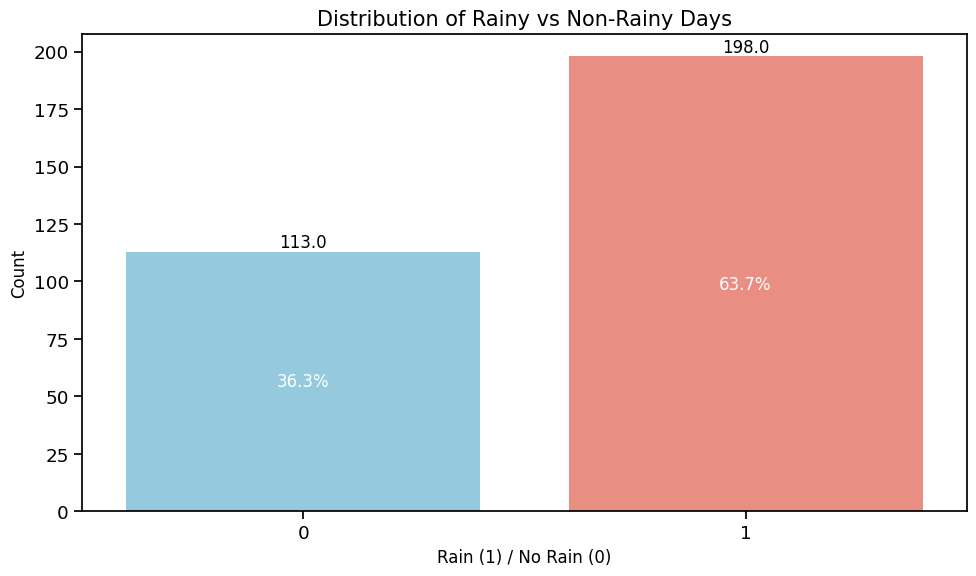

In [7]:
# Create a bar plot showing the distribution of rain vs no rain days
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='rain_or_not', data=df, palette=['skyblue', 'salmon'])
plt.title('Distribution of Rainy vs Non-Rainy Days', fontsize=15)
plt.xlabel('Rain (1) / No Rain (0)', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Add count labels on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', 
                (p.get_x() + p.get_width()/2., p.get_height()), 
                ha='center', va='bottom', fontsize=12)

# Add percentage labels
total = len(df)
for i, p in enumerate(ax.patches):
    percentage = 100 * p.get_height() / total
    ax.annotate(f'{percentage:.1f}%', 
                (p.get_x() + p.get_width()/2., p.get_height()/2), 
                ha='center', va='center', fontsize=12, color='white')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'target_distribution.png'))
plt.show()

## 4. Missing Data Visualization

Visualize any missing data patterns in our dataset.

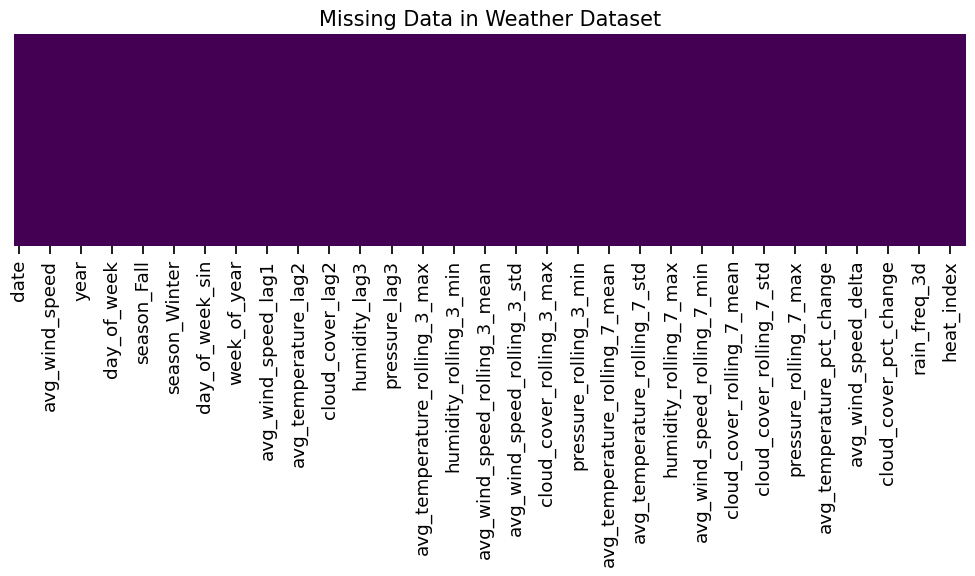

No missing values in the dataset.


In [8]:
# Visualize missing data
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.title('Missing Data in Weather Dataset', fontsize=15)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'missing_data.png'))
plt.show()

# Percentage of missing values by column
missing_pct = df.isnull().mean() * 100
if missing_pct.max() > 0:
    plt.figure(figsize=(10, 6))
    missing_pct = missing_pct[missing_pct > 0]
    missing_pct.sort_values(ascending=False).plot(kind='bar', color='coral')
    plt.title('Percentage of Missing Values by Feature', fontsize=15)
    plt.xlabel('Features', fontsize=12)
    plt.ylabel('Percentage Missing', fontsize=12)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'missing_percentage.png'))
    plt.show()
else:
    print("No missing values in the dataset.")

## 5. Feature Distribution Analysis

How key numerical features are distributed and how they relate to the target variable (rain_or_not).

In [9]:
def analyze_numeric_feature(df, feature, target='rain_or_not'):
    """Analyze a numeric feature with respect to the target variable"""
    plt.figure(figsize=(15, 10))
    
    # 1. Distribution Plot
    plt.subplot(2, 2, 1)
    sns.histplot(data=df, x=feature, hue=target, kde=True, bins=20, 
                 palette=['skyblue', 'salmon'], element='step', common_norm=False)
    plt.title(f'Distribution of {feature} by Rain Outcome', fontsize=12)
    
    # 2. Box Plot
    plt.subplot(2, 2, 2)                                                       
    sns.boxplot(x=target, y=feature, data=df, palette=['skyblue', 'salmon'])
    plt.title(f'Box Plot of {feature} by Rain Outcome', fontsize=12)
    
    # 3. Violin Plot
    plt.subplot(2, 2, 3)
    sns.violinplot(x=target, y=feature, data=df, palette=['skyblue', 'salmon'], inner='quartile')
    plt.title(f'Violin Plot of {feature} by Rain Outcome', fontsize=12)
    
    # 4. Density Plot
    plt.subplot(2, 2, 4)
    for value in sorted(df[target].unique()):
        subset = df[df[target] == value]
        sns.kdeplot(data=subset, x=feature, 
                    label=f'Rain={value}', 
                    color='salmon' if value==1 else 'skyblue',
                    fill=True, alpha=0.5)
    plt.title(f'Density Plot of {feature} by Rain Outcome', fontsize=12)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'{feature}_analysis.png'))
    plt.show()
    
    # Statistical Analysis
    print(f"\n=== {feature.upper()} ANALYSIS ===")
    print("Summary statistics by rain outcome:")
    display(df.groupby(target)[feature].describe())
    
    # T-test to check if means are significantly different
    rain = df[df[target] == 1][feature].dropna()
    no_rain = df[df[target] == 0][feature].dropna()
    
    if len(rain) > 0 and len(no_rain) > 0:
        t_stat, p_val = stats.ttest_ind(rain, no_rain, equal_var=False)
        print(f"\nT-test: {feature} difference between rainy vs non-rainy days")
        print(f"t-statistic: {t_stat:.4f}, p-value: {p_val:.4f}")
        significance = "significant" if p_val < 0.05 else "not significant"
        print(f"The difference is statistically {significance} at 5% level")
        
        # Calculate the mean difference
        mean_diff = rain.mean() - no_rain.mean()
        print(f"Mean difference (Rain - No Rain): {mean_diff:.4f}")
    else:
        print(f"Unable to perform t-test for {feature} due to insufficient data.")

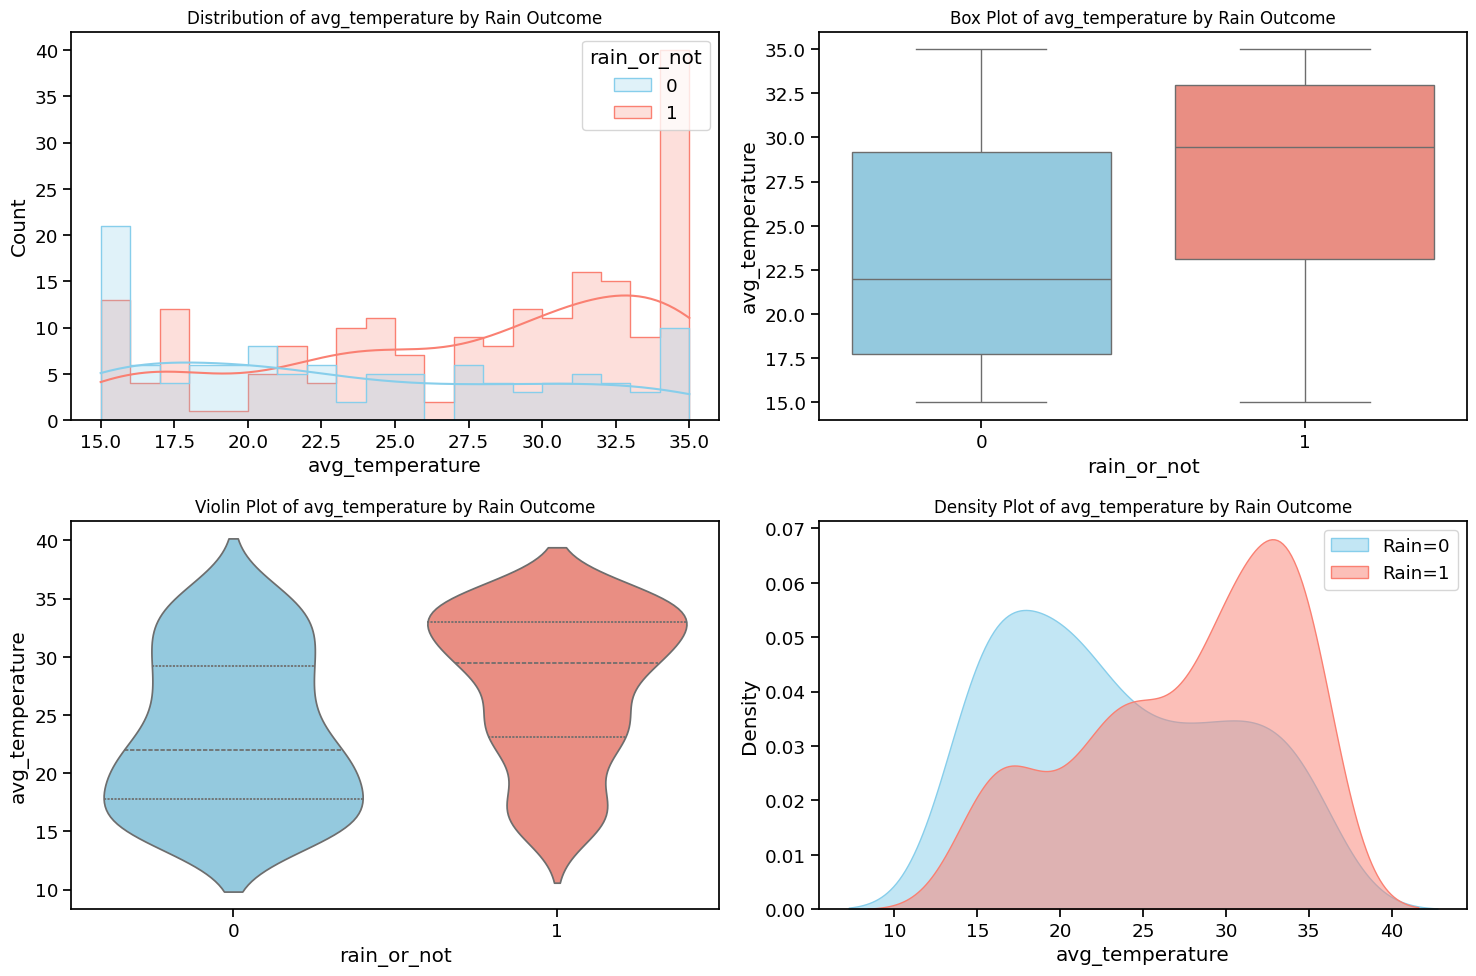


=== AVG_TEMPERATURE ANALYSIS ===
Summary statistics by rain outcome:


,count,mean,std,min,25%,50%,75%,max
rain_or_not,,,,,,,,
0,113.0,23.396833,6.658292,15.0,17.760062,22.003189,29.188297,35.0
1,198.0,27.592466,6.348849,15.0,23.134626,29.433505,32.980120,35.0



T-test: avg_temperature difference between rainy vs non-rainy days
t-statistic: 5.4351, p-value: 0.0000
The difference is statistically significant at 5% level
Mean difference (Rain - No Rain): 4.1956


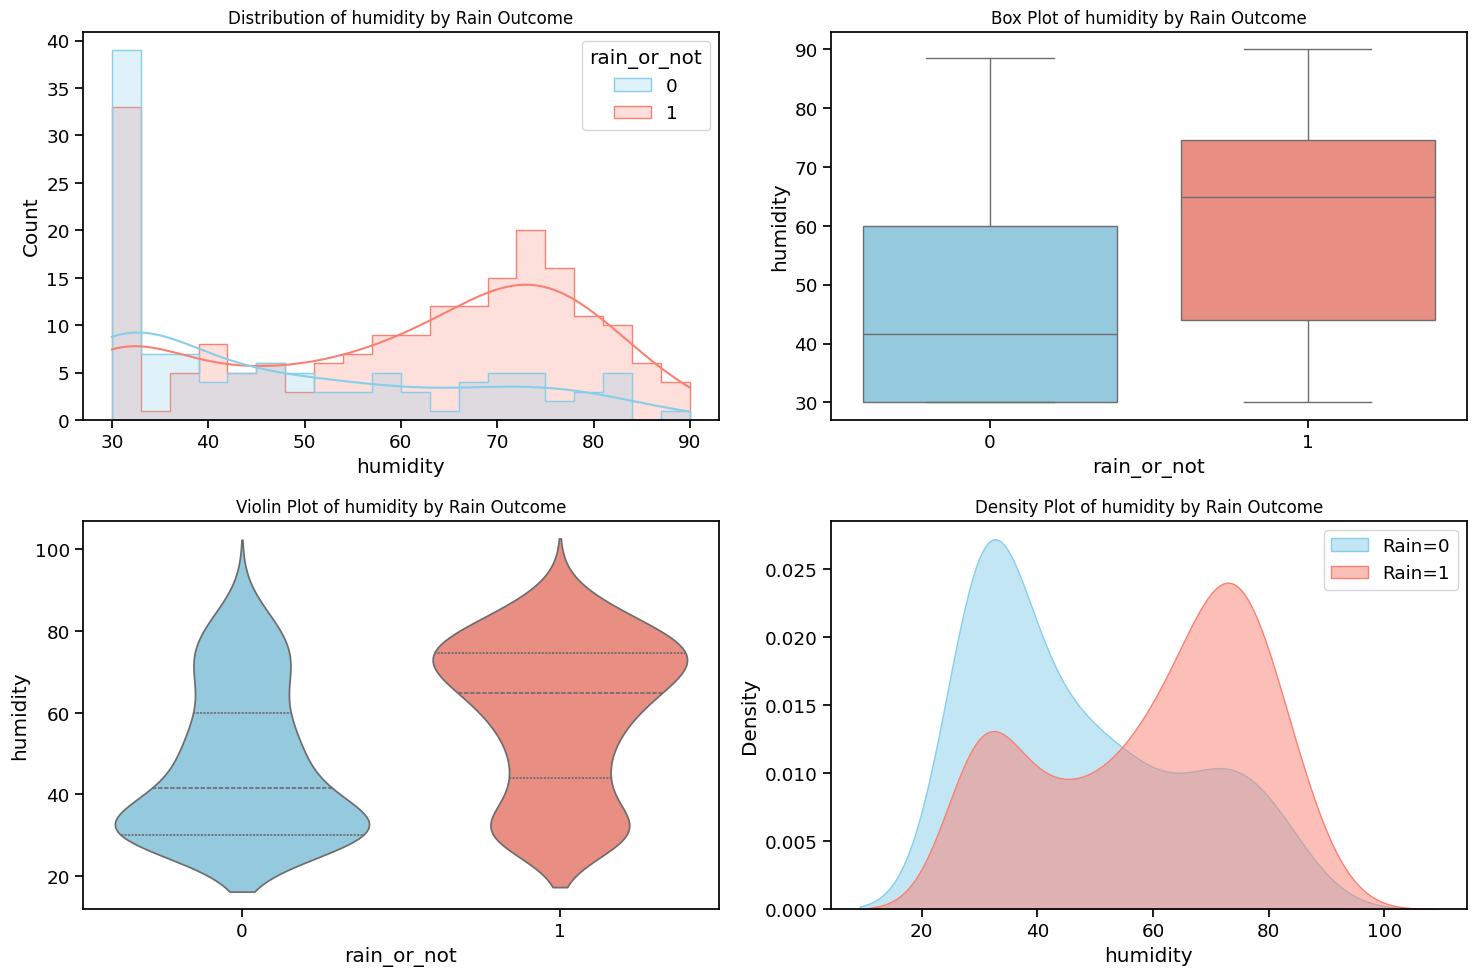


=== HUMIDITY ANALYSIS ===
Summary statistics by rain outcome:


,count,mean,std,min,25%,50%,75%,max
rain_or_not,,,,,,,,
0,113.0,47.199895,17.767585,30.0,30.000000,41.602938,60.033848,88.564001
1,198.0,59.940129,18.295551,30.0,44.062648,64.894210,74.630300,90.000000



T-test: humidity difference between rainy vs non-rainy days
t-statistic: 6.0164, p-value: 0.0000
The difference is statistically significant at 5% level
Mean difference (Rain - No Rain): 12.7402


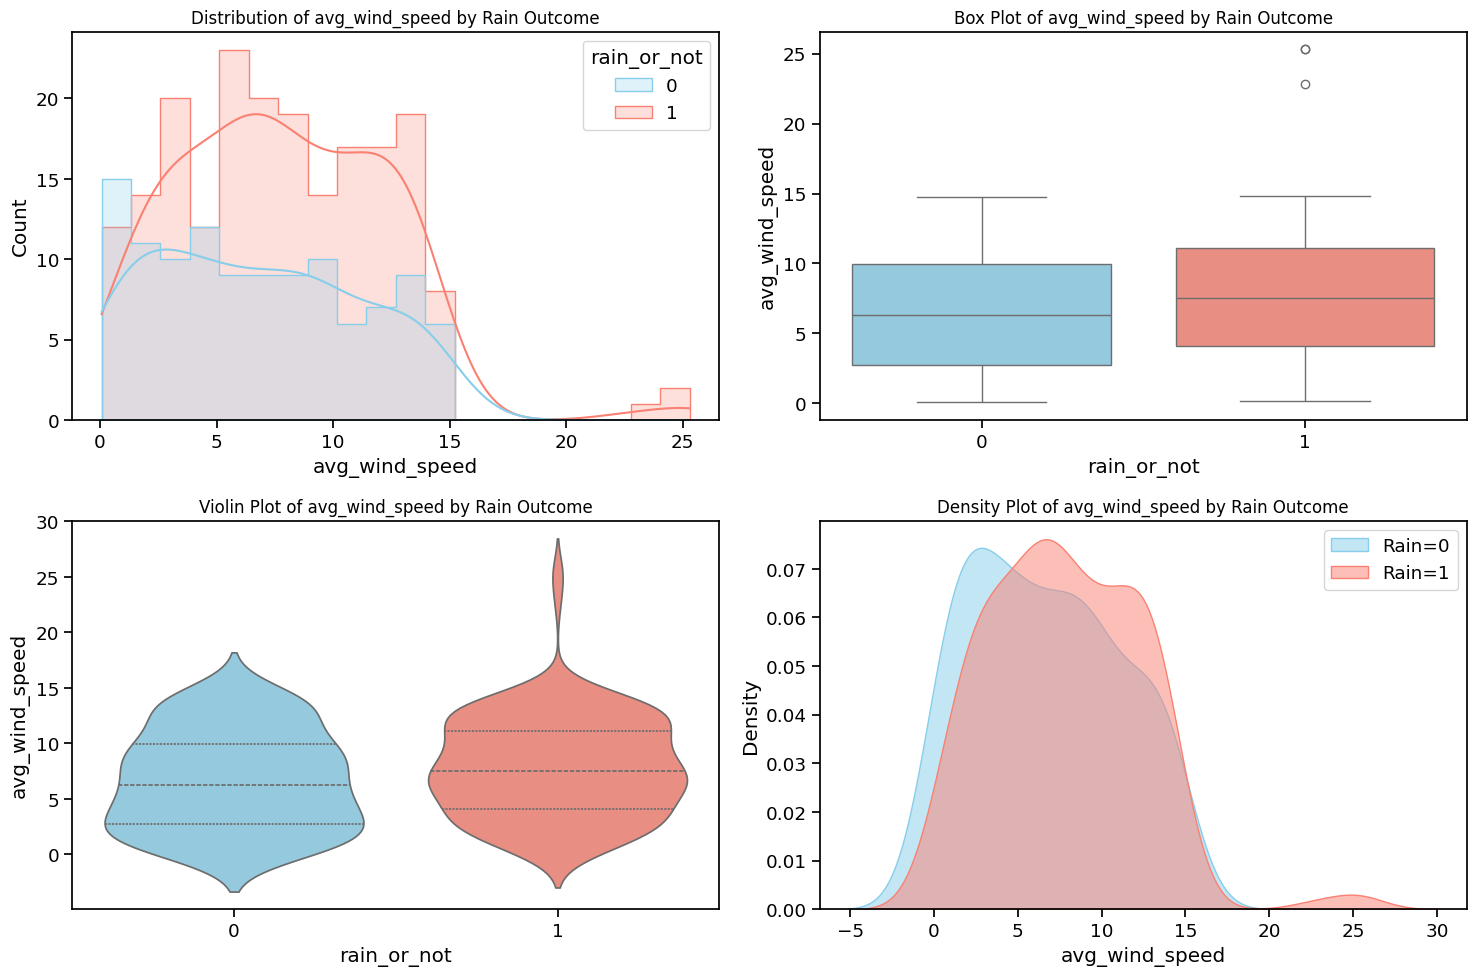


=== AVG_WIND_SPEED ANALYSIS ===
Summary statistics by rain outcome:


,count,mean,std,min,25%,50%,75%,max
rain_or_not,,,,,,,,
0,113.0,6.679679,4.399988,0.069480,2.708630,6.283882,9.953061,14.772618
1,198.0,7.839832,4.528455,0.164937,4.066422,7.504221,11.137022,25.315232



T-test: avg_wind_speed difference between rainy vs non-rainy days
t-statistic: 2.2127, p-value: 0.0279
The difference is statistically significant at 5% level
Mean difference (Rain - No Rain): 1.1602


In [10]:
# Analyze main weather variables
key_features = ['avg_temperature', 'humidity', 'avg_wind_speed']

for feature in key_features:
    if feature in df.columns:
        analyze_numeric_feature(df, feature)
    else:
        print(f"Feature '{feature}' not found in dataset.")

## 6. Time Series Analysis

How weather features change over time and identify any patterns related to rain events.

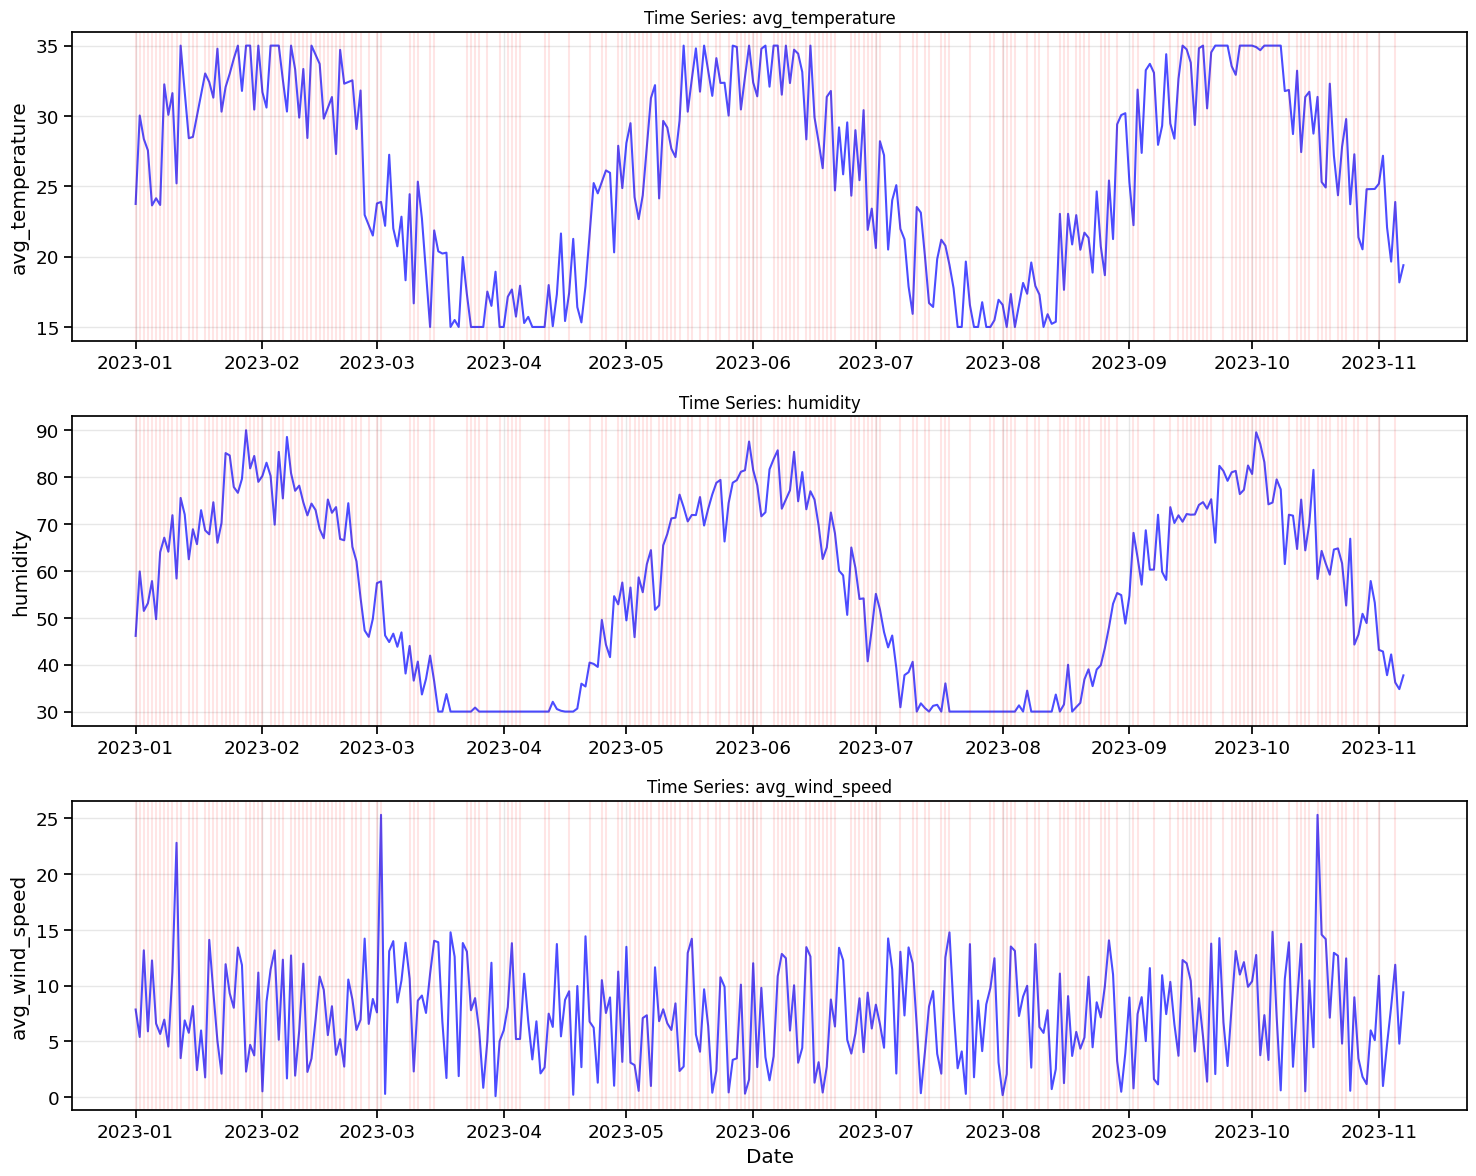

In [11]:
def plot_time_series(df, features):
    """Create time series plots for specified features, highlighting rain events"""
    # Ensure data is sorted by date
    df = df.sort_values('date')
    
    plt.figure(figsize=(15, 12))
    # Plot each feature with rain events highlighted
    for i, feature in enumerate(features, 1):
        if feature not in df.columns:
            print(f"Feature '{feature}' not found in dataset. Skipping...")
            continue
            
        plt.subplot(len(features), 1, i)
        
        # Plot feature values
        plt.plot(df['date'], df[feature], '-', color='blue', alpha=0.7)
        
        # Plot rainy days for reference
        rain_days = df[df['rain_or_not'] == 1]['date']
        y_min, y_max = plt.ylim()
        for date in rain_days:
            plt.axvline(x=date, color='red', alpha=0.1)
        
        plt.title(f'Time Series: {feature}', fontsize=12)
        plt.ylabel(feature)
        if i == len(features):  # Only add x-label to bottom plot
            plt.xlabel('Date')
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'time_series_analysis.png'))
    plt.show()

# Plot time series for main features
available_features = [f for f in ['avg_temperature', 'humidity', 'avg_wind_speed'] if f in df.columns]
plot_time_series(df, available_features)

## 7. Seasonal Analysis

How rainfall patterns vary by month and day of week to identify seasonal trends.

In [12]:
# Add month and day of week features if not already present
if 'date' in df.columns:
    if 'month' not in df.columns:
        df['month'] = df['date'].dt.month
    if 'month_name' not in df.columns:
        df['month_name'] = df['date'].dt.month.apply(lambda x: calendar.month_name[x])
    if 'day_of_week' not in df.columns:
        df['day_of_week'] = df['date'].dt.dayofweek
    if 'season' not in df.columns:
        # Define seasons: Winter (12,1,2), Spring (3,4,5), Summer (6,7,8), Fall (9,10,11)
        season_dict = {12: 'Winter', 1: 'Winter', 2: 'Winter',
                       3: 'Spring', 4: 'Spring', 5: 'Spring',
                       6: 'Summer', 7: 'Summer', 8: 'Summer',
                       9: 'Fall', 10: 'Fall', 11: 'Fall'}  
        df['season'] = df['date'].dt.month.map(season_dict)

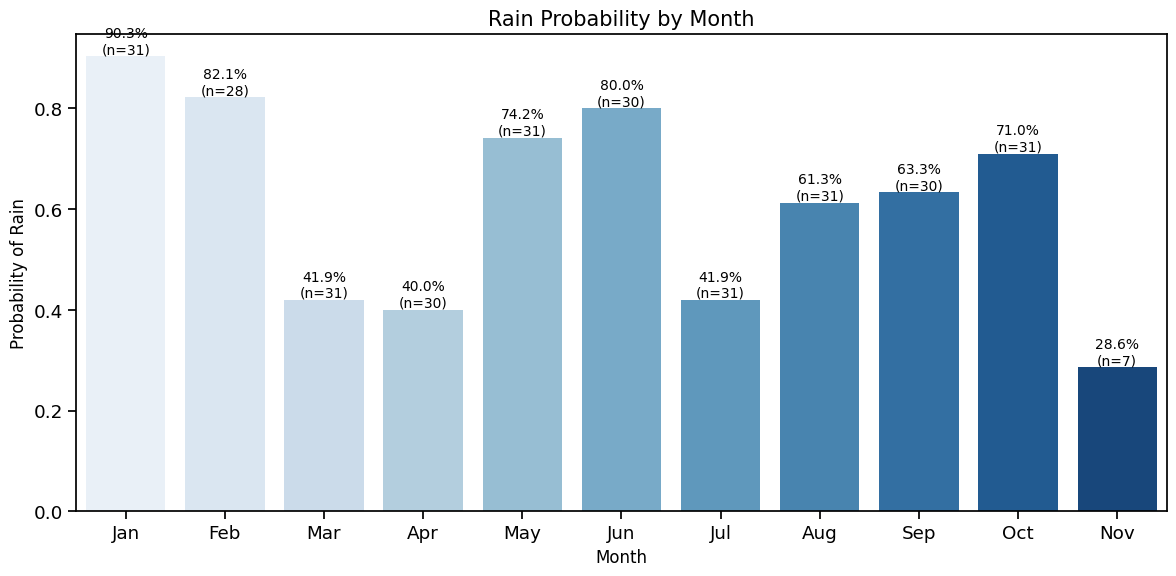


=== SEASONAL ANALYSIS ===
Chi-square test for rain ~ month: chi2=43.04, p-value=0.0000
There is a significant association between month and rainfall


In [13]:
# A. Rain probability by month
if 'month' in df.columns:
    plt.figure(figsize=(12, 6))
    monthly_rain = df.groupby('month')['rain_or_not'].mean().reset_index()
    monthly_counts = df.groupby('month').size().reset_index(name='count')
    monthly_data = pd.merge(monthly_rain, monthly_counts)
    
    # Add month names for readability
    monthly_data['month_name'] = monthly_data['month'].apply(lambda x: calendar.month_abbr[x])
    
    ax = sns.barplot(x='month', y='rain_or_not', data=monthly_data, palette='Blues')
    plt.title('Rain Probability by Month', fontsize=15)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Probability of Rain', fontsize=12)
    
    # Customize x-axis labels to show month names
    plt.xticks(ticks=range(len(monthly_data)), labels=monthly_data['month_name'])
    
    # Add percentage labels
    for i, p in enumerate(ax.patches):
        percentage = p.get_height() * 100
        count = monthly_data.iloc[i]['count']
        ax.annotate(f'{percentage:.1f}%\n(n={count})', 
                    (p.get_x() + p.get_width()/2., p.get_height()), 
                    ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'rain_by_month.png'))
    plt.show()
    
    # Chi-square test for independence
    month_contingency = pd.crosstab(df['month'], df['rain_or_not'])
    chi2, p, dof, expected = chi2_contingency(month_contingency)
    print("\n=== SEASONAL ANALYSIS ===")
    print(f"Chi-square test for rain ~ month: chi2={chi2:.2f}, p-value={p:.4f}")
    if p < 0.05:
        print("There is a significant association between month and rainfall")
    else:
        print("No significant association between month and rainfall")

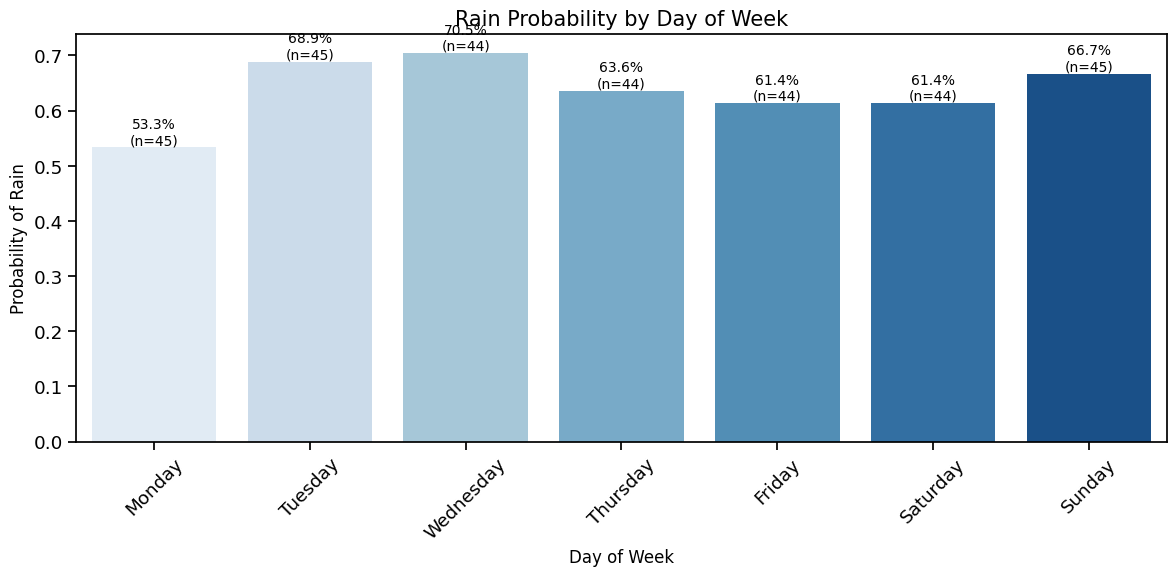

In [14]:
# B. Rain probability by day of week
if 'day_of_week' in df.columns:
    plt.figure(figsize=(12, 6))
    daily_rain = df.groupby('day_of_week')['rain_or_not'].mean().reset_index()
    daily_counts = df.groupby('day_of_week').size().reset_index(name='count')
    daily_data = pd.merge(daily_rain, daily_counts)
    
    # Map day numbers to names
    day_names = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 
                 4:'Friday', 5:'Saturday', 6:'Sunday'}
    daily_data['day_name'] = daily_data['day_of_week'].map(day_names)
    
    ax = sns.barplot(x='day_name', y='rain_or_not', data=daily_data, palette='Blues')
    plt.title('Rain Probability by Day of Week', fontsize=15)
    plt.xlabel('Day of Week', fontsize=12)
    plt.ylabel('Probability of Rain', fontsize=12)
    plt.xticks(rotation=45)
    
    # Add percentage labels
    for i, p in enumerate(ax.patches):
        percentage = p.get_height() * 100
        count = daily_data.iloc[i]['count']
        ax.annotate(f'{percentage:.1f}%\n(n={count})', 
                    (p.get_x() + p.get_width()/2., p.get_height()), 
                    ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'rain_by_weekday.png'))
    plt.show()

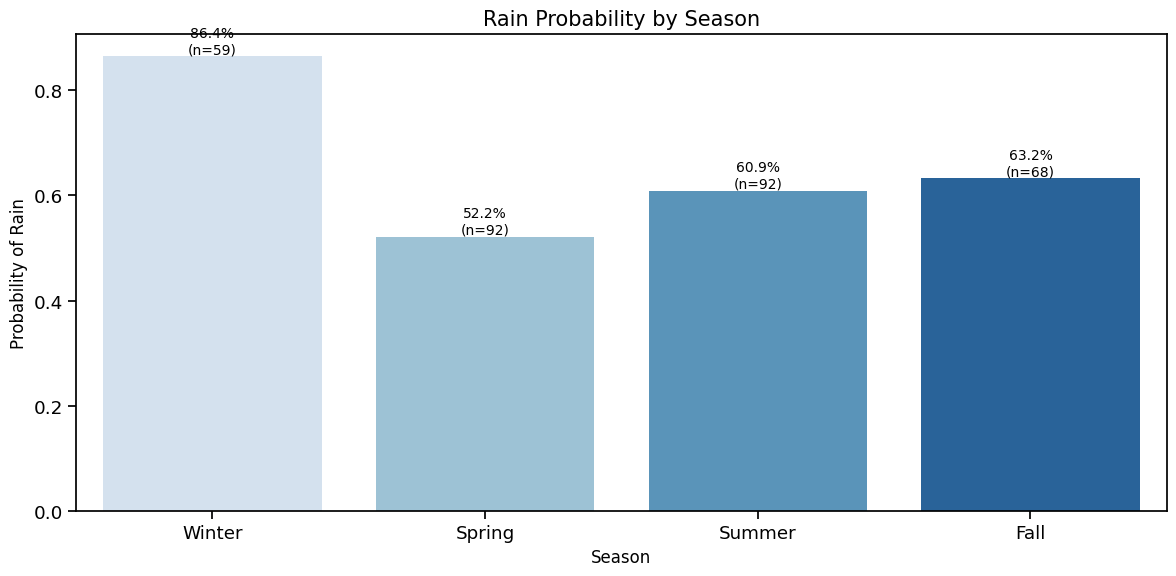

In [15]:
# C. Rain probability by season
if 'season' in df.columns:
    plt.figure(figsize=(12, 6))
    season_rain = df.groupby('season')['rain_or_not'].mean().reset_index()
    season_counts = df.groupby('season').size().reset_index(name='count')
    season_data = pd.merge(season_rain, season_counts)
    
    # Ensure seasons are in correct order
    season_order = ['Winter', 'Spring', 'Summer', 'Fall']
    season_data['season'] = pd.Categorical(season_data['season'], categories=season_order, ordered=True)
    season_data = season_data.sort_values('season')
    
    ax = sns.barplot(x='season', y='rain_or_not', data=season_data, palette='Blues')
    plt.title('Rain Probability by Season', fontsize=15)
    plt.xlabel('Season', fontsize=12)
    plt.ylabel('Probability of Rain', fontsize=12)
    
    # Add percentage labels
    for i, p in enumerate(ax.patches):
        percentage = p.get_height() * 100
        count = season_data.iloc[i]['count']
        ax.annotate(f'{percentage:.1f}%\n(n={count})', 
                    (p.get_x() + p.get_width()/2., p.get_height()), 
                    ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'rain_by_season.png'))
    plt.show()

## 8. Correlation Analysis

Relationships between weather features and identify those most closely associated with rainfall.

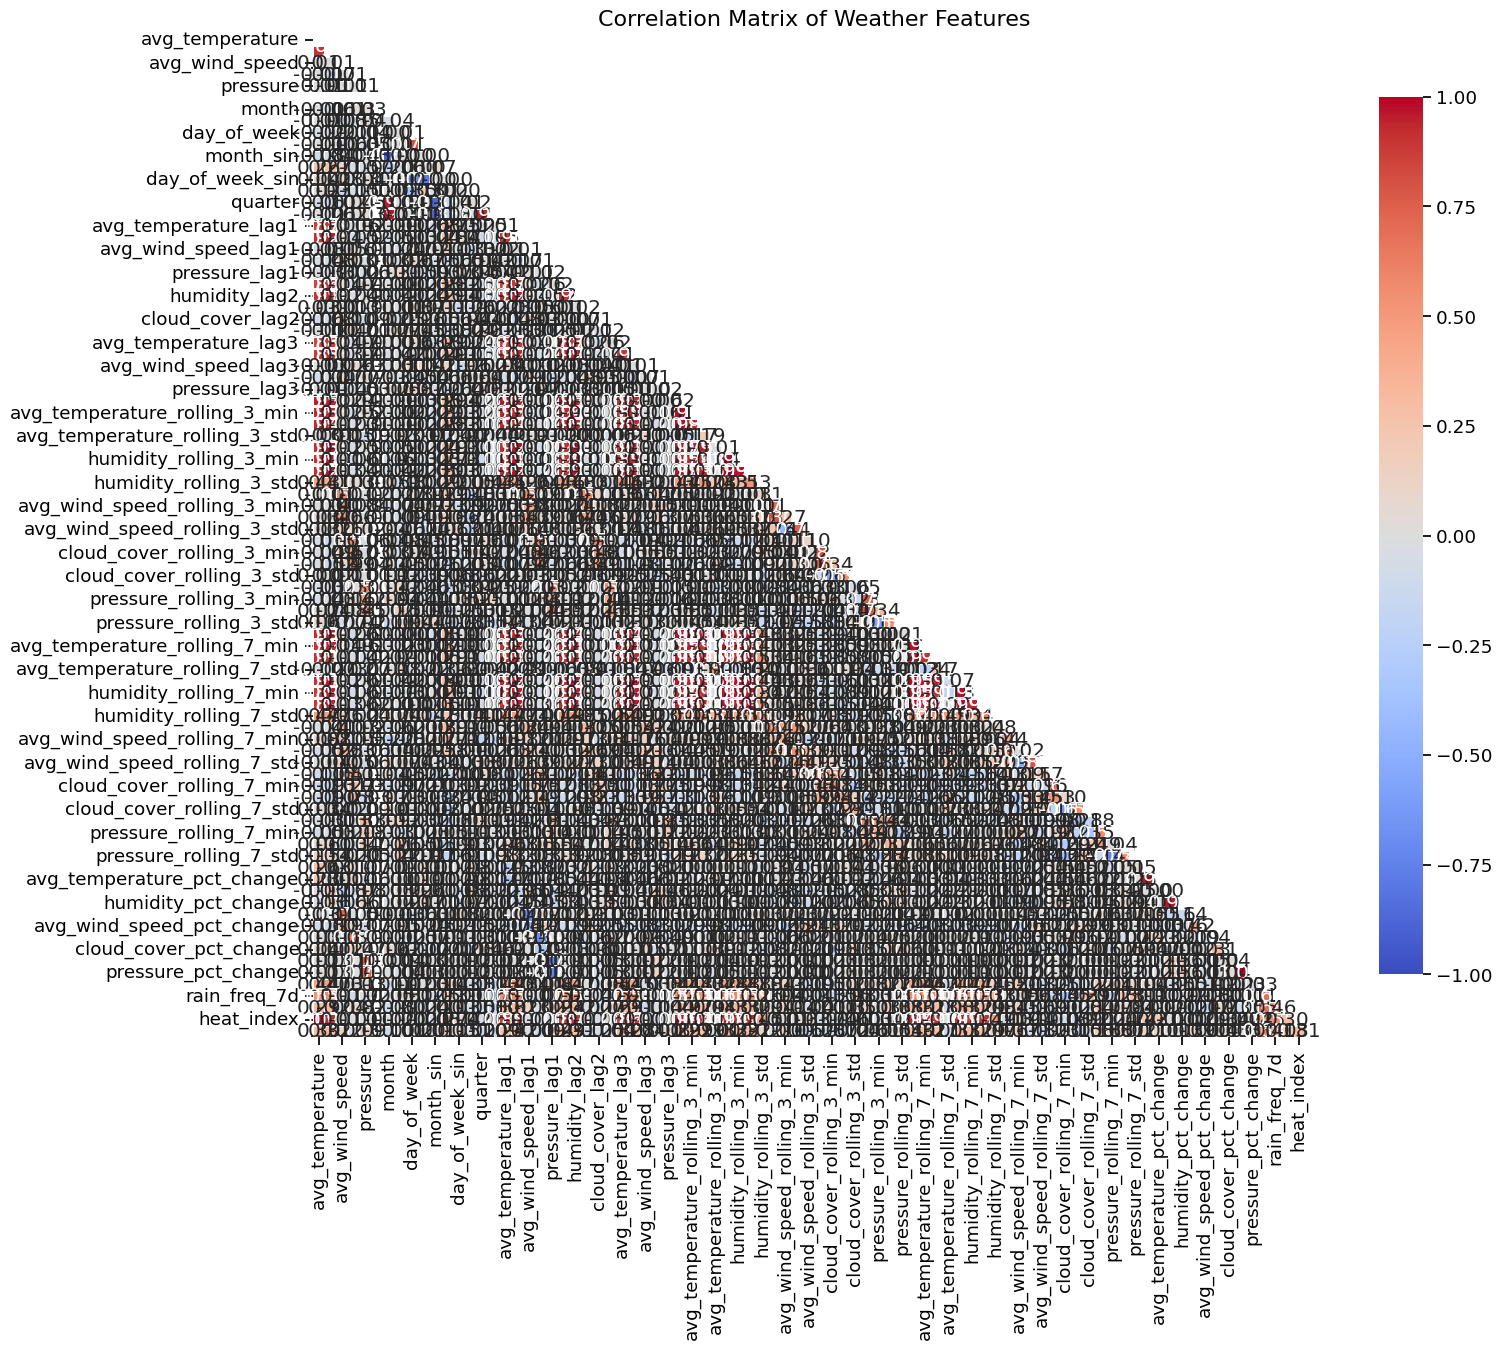


=== CORRELATION WITH RAIN ===


,Correlation with rain_or_not


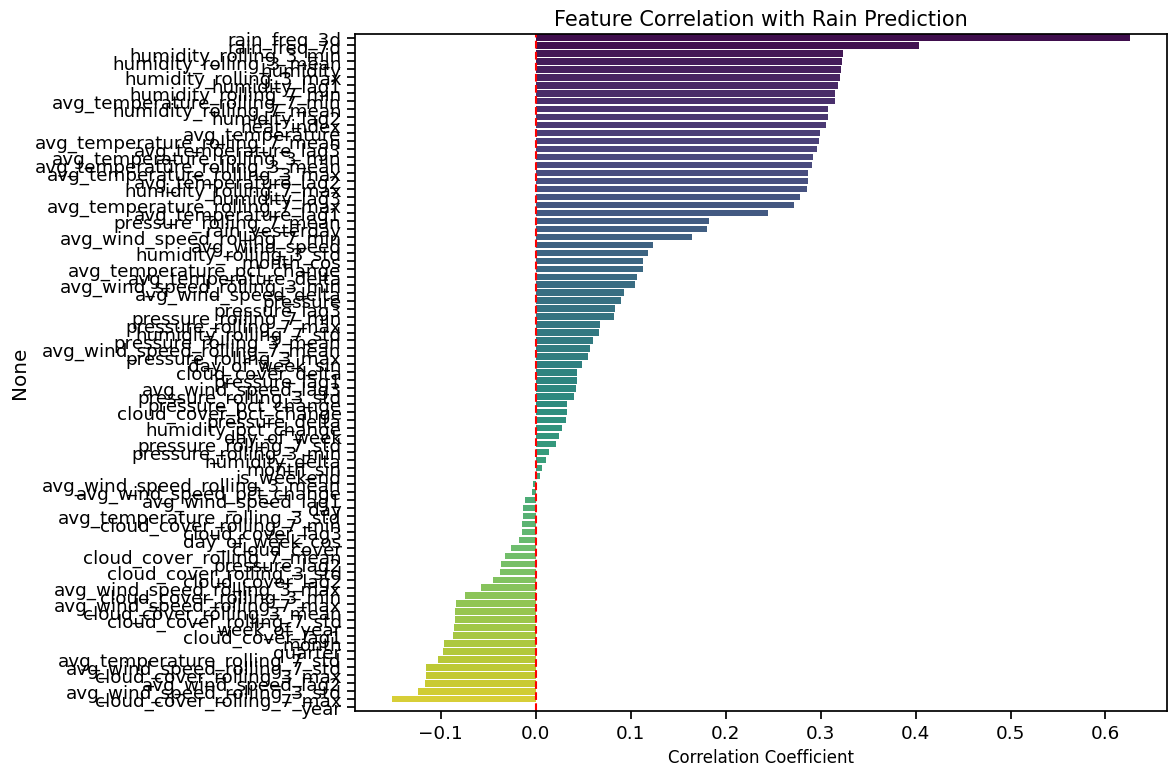

In [16]:
# Select only numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_df = df[numeric_cols]

# Create correlation matrix
corr_matrix = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(16, 14))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Mask for upper triangle
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
            linewidths=0.5, vmin=-1, vmax=1, square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Weather Features', fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'correlation_heatmap.png'))
plt.show()

# Show top correlations with target
if 'rain_or_not' in numeric_cols:
    target_corr = corr_matrix['rain_or_not'].drop('rain_or_not').sort_values(ascending=False)
    print("\n=== CORRELATION WITH RAIN ===")
    display(pd.DataFrame(target_corr, columns=['Correlation with rain_or_not']))
    
    # Visualize top correlations with target
    plt.figure(figsize=(12, 8))
    sns.barplot(x=target_corr.values, y=target_corr.index, palette='viridis')
    plt.title('Feature Correlation with Rain Prediction', fontsize=15)
    plt.xlabel('Correlation Coefficient', fontsize=12)
    plt.axvline(x=0, color='red', linestyle='--')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'target_correlation.png'))
    plt.show()

## 9. Mutual Information Analysis

Mutual information to identify non-linear relationships between features and target variable.


=== MUTUAL INFORMATION ANALYSIS ===
Top features by mutual information score:


,Feature,MI_Score
0,rain_freq_3d,0.238047
1,rain_freq_7d,0.120686
2,avg_temperature_rolling_7_mean,0.088205
3,avg_temperature_rolling_7_min,0.087376
4,humidity_rolling_3_min,0.077162
...,...,...
80,humidity_rolling_7_std,0.000000
81,cloud_cover_lag2,0.000000
82,pressure_lag2,0.000000
83,cloud_cover_lag3,0.000000


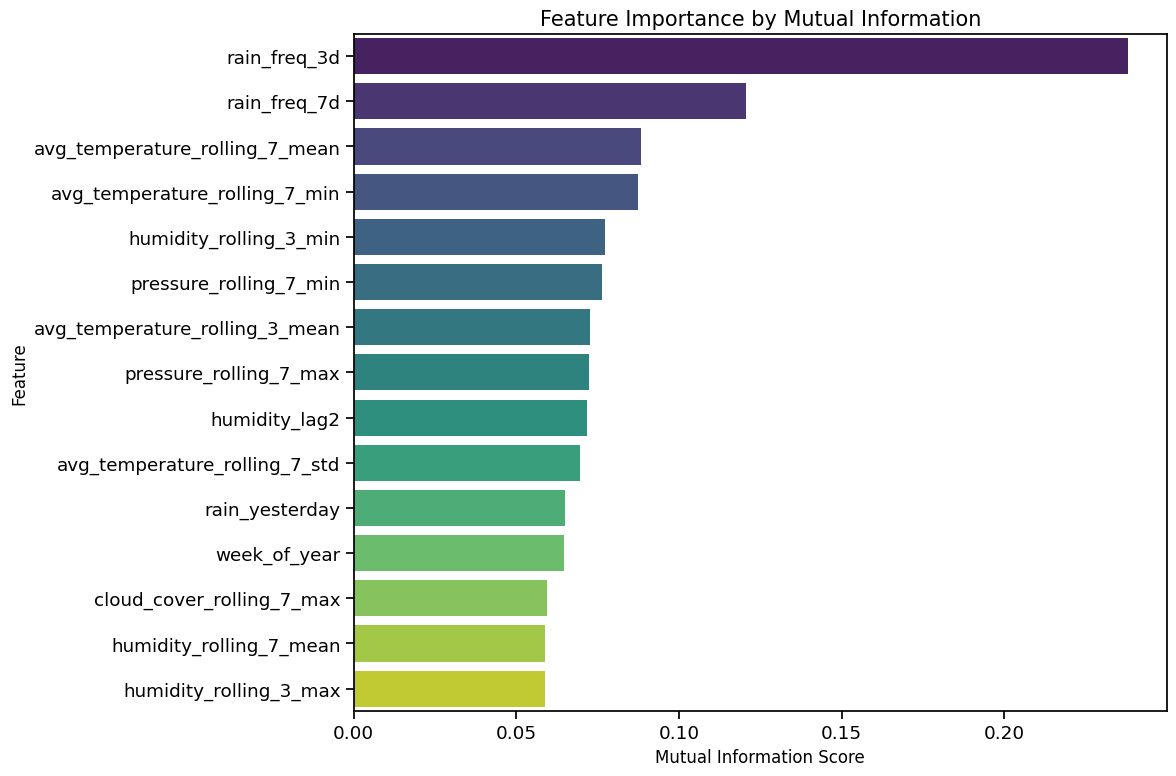

In [17]:
# Select features (excluding target and date)
if 'rain_or_not' in df.columns:
    X = df.drop(['rain_or_not', 'date'], axis=1, errors='ignore')
    y = df['rain_or_not']
    
    # Handle non-numeric columns for MI calculation
    X_numeric = X.select_dtypes(include=[np.number])
    
    if not X_numeric.empty:
        # Calculate mutual information
        mi_scores = mutual_info_classif(X_numeric, y, random_state=42)
        mi_df = pd.DataFrame({'Feature': X_numeric.columns, 'MI_Score': mi_scores})
        mi_df = mi_df.sort_values('MI_Score', ascending=False).reset_index(drop=True)
        
        print("\n=== MUTUAL INFORMATION ANALYSIS ===")
        print("Top features by mutual information score:")
        display(mi_df)
        
        # Visualize mutual information
        plt.figure(figsize=(12, 8))
        sns.barplot(x='MI_Score', y='Feature', data=mi_df.head(15), palette='viridis')
        plt.title('Feature Importance by Mutual Information', fontsize=15)
        plt.xlabel('Mutual Information Score', fontsize=12)
        plt.ylabel('Feature', fontsize=12)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'mutual_information.png'))
        plt.show()
    else:
        print("No numeric features available for mutual information analysis.")

## 10. Feature Interaction Analysis

How combinations of features interact to influence rainfall probability.

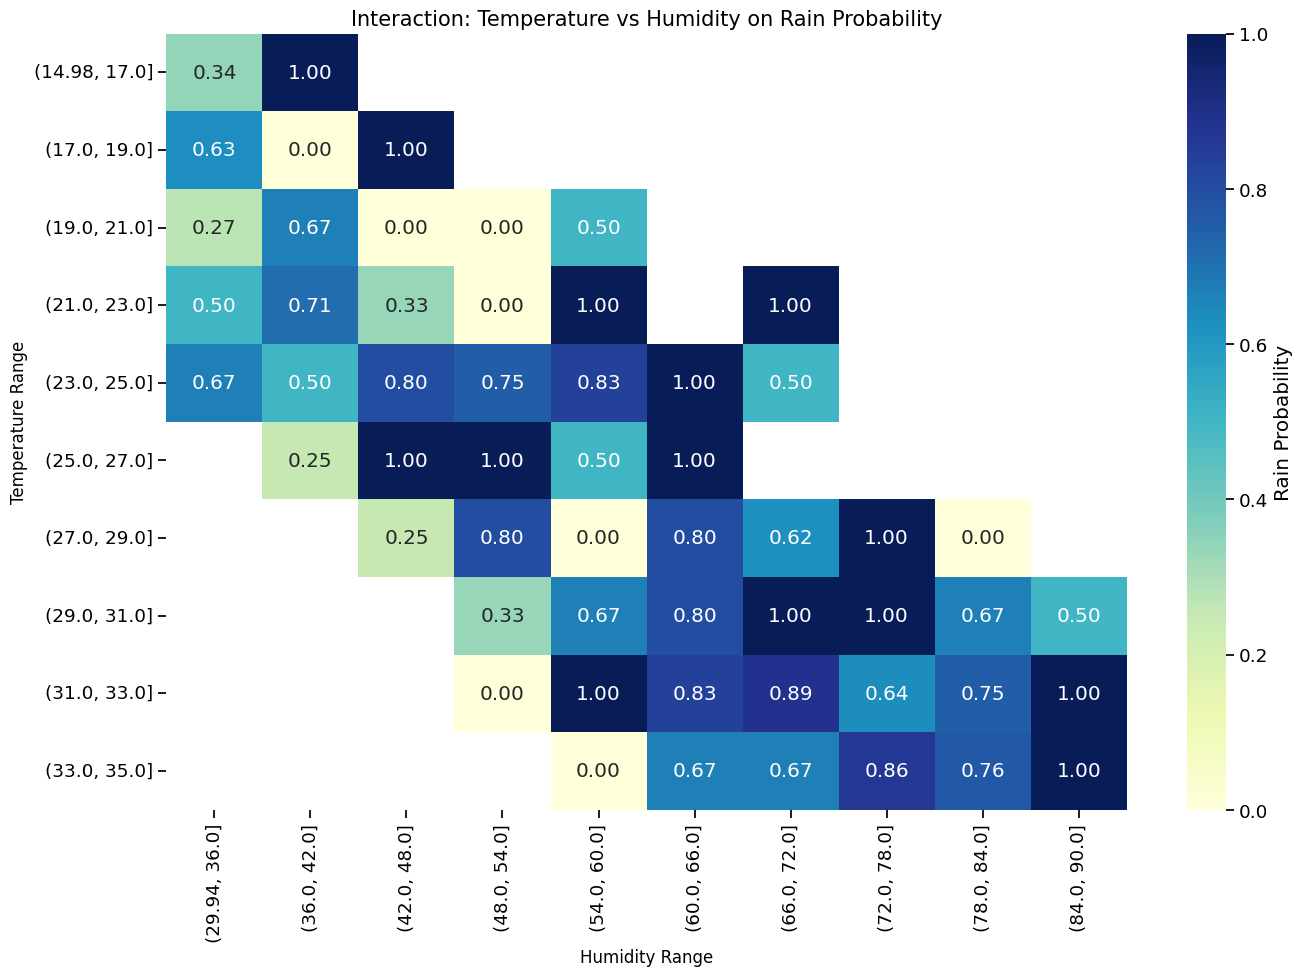

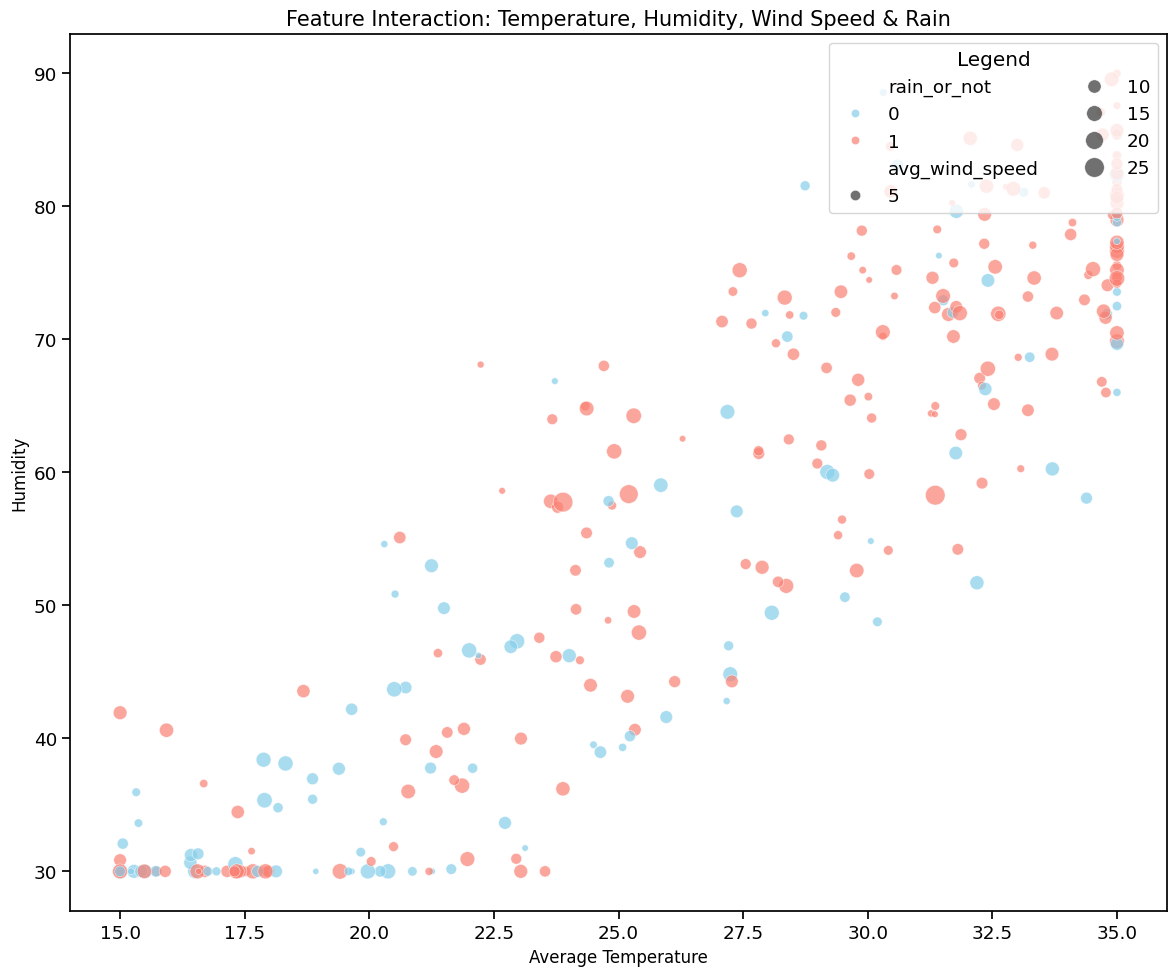

In [18]:
# Example: Temperature and Humidity interaction
if all(x in df.columns for x in ['avg_temperature', 'humidity', 'rain_or_not']):
    # Create binned variables for heatmap
    df['temp_bin'] = pd.cut(df['avg_temperature'], bins=10)
    df['humidity_bin'] = pd.cut(df['humidity'], bins=10)
    
    # Calculate rain probability for each bin combination
    heatmap_data = df.groupby(['temp_bin', 'humidity_bin'])['rain_or_not'].mean().reset_index()
    heatmap_pivot = heatmap_data.pivot_table(
        values='rain_or_not', 
        index='temp_bin', 
        columns='humidity_bin'
    )
    
    plt.figure(figsize=(14, 10))
    sns.heatmap(heatmap_pivot, annot=True, fmt='.2f', cmap='YlGnBu', cbar_kws={'label': 'Rain Probability'})
    plt.title('Interaction: Temperature vs Humidity on Rain Probability', fontsize=15)
    plt.xlabel('Humidity Range', fontsize=12)
    plt.ylabel('Temperature Range', fontsize=12)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'temp_humidity_interaction.png'))
    plt.show()
    
    # Additional feature interaction
    if 'avg_wind_speed' in df.columns:
        # Create a scatter plot with multiple dimensions
        plt.figure(figsize=(12, 10))
        scatter = sns.scatterplot(x='avg_temperature', y='humidity', 
                                 hue='rain_or_not', size='avg_wind_speed',
                                 palette=['skyblue', 'salmon'],
                                 sizes=(20, 200), alpha=0.7, data=df)
        plt.title('Feature Interaction: Temperature, Humidity, Wind Speed & Rain', fontsize=15)
        plt.xlabel('Average Temperature', fontsize=12)
        plt.ylabel('Humidity', fontsize=12)
        scatter.legend(title='Legend', loc='upper right', ncol=2)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'feature_interaction_scatter.png'))
        plt.show()

## 11. Time Lag Analysis

Weather patterns often show autocorrelation. Analyze time lags to understand temporal dependencies.

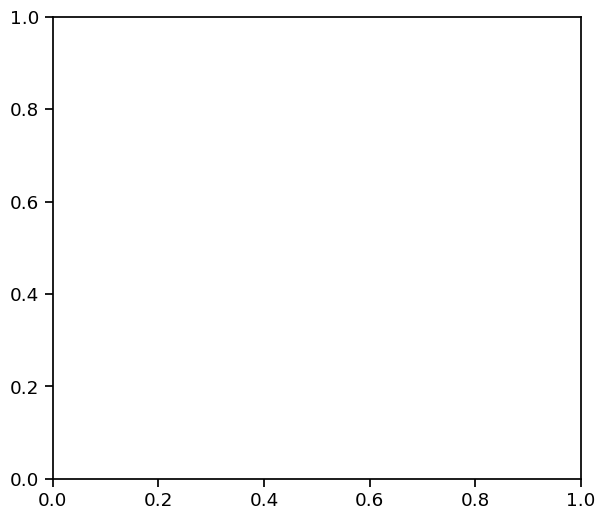

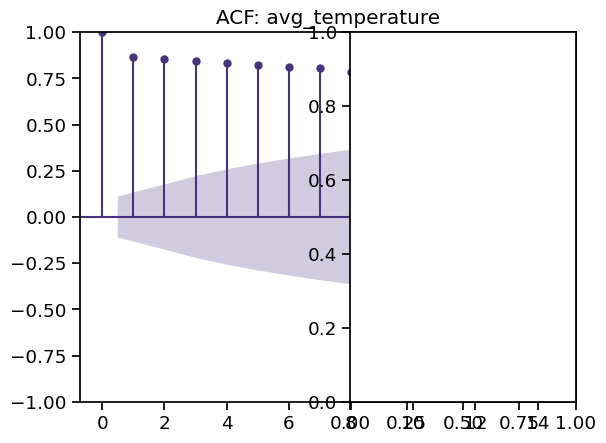

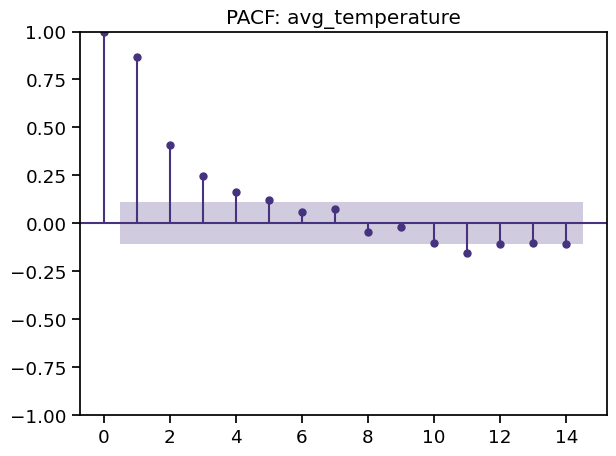

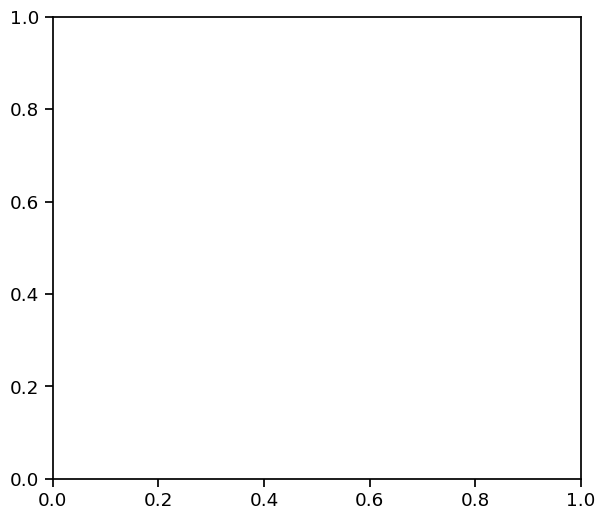

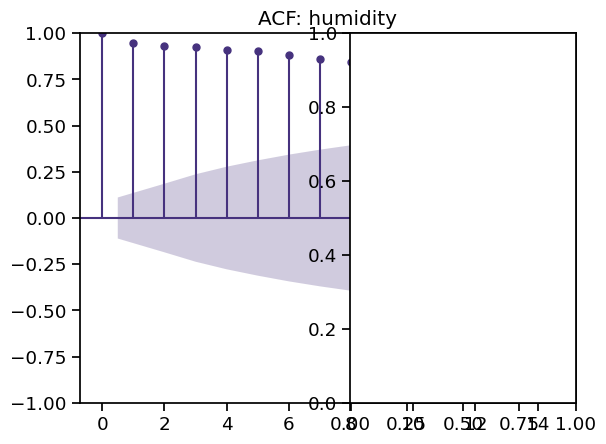

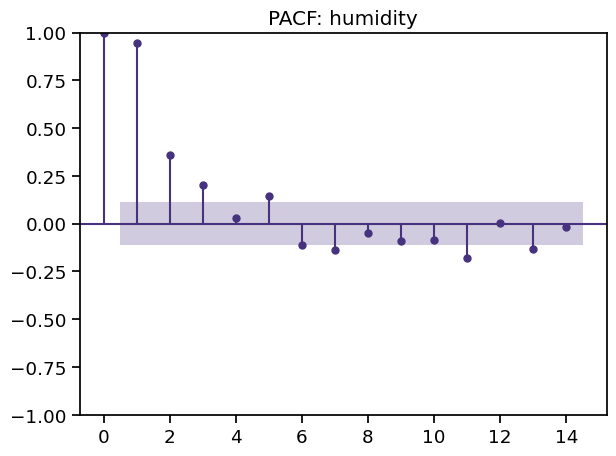

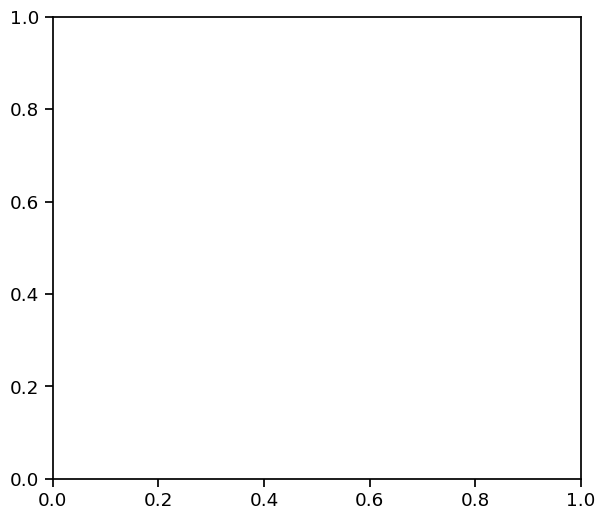

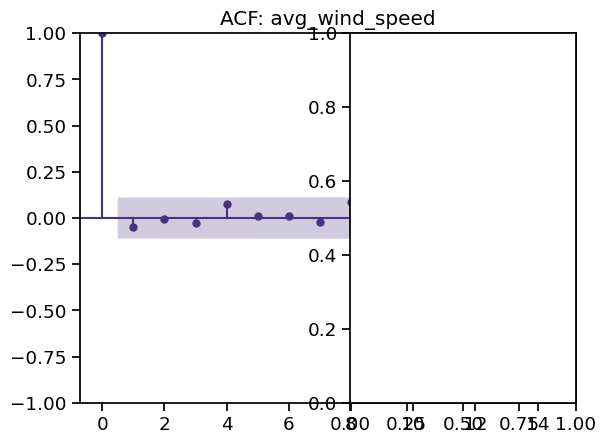

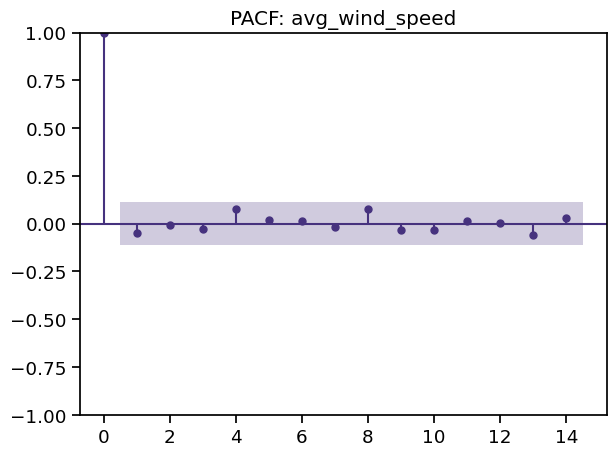

In [19]:
if 'date' in df.columns:
    # Ensure data is sorted by date
    df = df.sort_values('date')
    
    for feature in ['avg_temperature', 'humidity', 'avg_wind_speed']:
        if feature in df.columns:
            plt.figure(figsize=(15, 6))
            
            # ACF plot
            plt.subplot(1, 2, 1)
            try:
                plot_acf(df[feature].dropna(), lags=14, alpha=0.05, title=f'ACF: {feature}')
            except Exception as e:
                print(f"Error creating ACF plot for {feature}: {e}")
            
            # PACF plot
            plt.subplot(1, 2, 2)
            try:
                plot_pacf(df[feature].dropna(), lags=14, alpha=0.05, title=f'PACF: {feature}')
            except Exception as e:
                print(f"Error creating PACF plot for {feature}: {e}")
            
            plt.tight_layout()
            plt.savefig(os.path.join(output_dir, f'acf_pacf_{feature}.png'))
            plt.show()

## 12. Rain Sequence Analysis

Analyze patterns in consecutive rainy days to understand weather persistence.

In [21]:
if 'rain_or_not' in df.columns and 'date' in df.columns:
    # Ensure data is sorted by date
    df = df.sort_values('date').reset_index(drop=True)
    
    # Create a feature for consecutive rainy days
    df['rain_streak'] = (df['rain_or_not'] != df['rain_or_not'].shift(1)).cumsum()
    df['rain_streak_group'] = df.groupby(['rain_streak', 'rain_or_not']).cumcount() + 1
    
    # Get max streak lengths
    rain_streaks = df[df['rain_or_not'] == 1].groupby('rain_streak')['rain_streak_group'].max().reset_index()
    no_rain_streaks = df[df['rain_or_not'] == 0].groupby('rain_streak')['rain_streak_group'].max().reset_index()
    
    print("\n=== RAIN SEQUENCE ANALYSIS ===")
    print(f"Longest rain streak: {rain_streaks['rain_streak_group'].max()} days")
    print(f"Longest dry streak: {no_rain_streaks['rain_streak_group'].max()} days")
    print(f"Average rain streak: {rain_streaks['rain_streak_group'].mean():.2f} days")
    print(f"Average dry streak: {no_rain_streaks['rain_streak_group'].mean():.2f} days")
    
    # Visualize streak distribution
    # Visualize streak distribution
if 'rain_or_not' in df.columns and 'date' in df.columns:
    # Ensure data is sorted by date
    df = df.sort_values('date').reset_index(drop=True)


    # Create a feature for consecutive rainy days
    df['rain_streak'] = (df['rain_or_not'] != df['rain_or_not'].shift(1)).cumsum()
    df['rain_streak_group'] = df.groupby(['rain_streak', 'rain_or_not']).cumcount() + 1

    # Get max streak lengths
    rain_streaks = df[df['rain_or_not'] == 1].groupby('rain_streak')['rain_streak_group'].max().reset_index()
    no_rain_streaks = df[df['rain_or_not'] == 0].groupby('rain_streak')['rain_streak_group'].max().reset_index()

    print("\n=== RAIN SEQUENCE ANALYSIS ===")
    print(f"Longest rain streak: {rain_streaks['rain_streak_group'].max()} days")
    print(f"Longest dry streak: {no_rain_streaks['rain_streak_group'].max()} days")
    print(f"Average rain streak: {rain_streaks['rain_streak_group'].mean():.2f} days")
    print(f"Average dry streak: {no_rain_streaks['rain_streak_group'].mean():.2f} days")


=== RAIN SEQUENCE ANALYSIS ===
Longest rain streak: 14 days
Longest dry streak: 7 days
Average rain streak: 3.36 days
Average dry streak: 1.92 days

=== RAIN SEQUENCE ANALYSIS ===
Longest rain streak: 14 days
Longest dry streak: 7 days
Average rain streak: 3.36 days
Average dry streak: 1.92 days


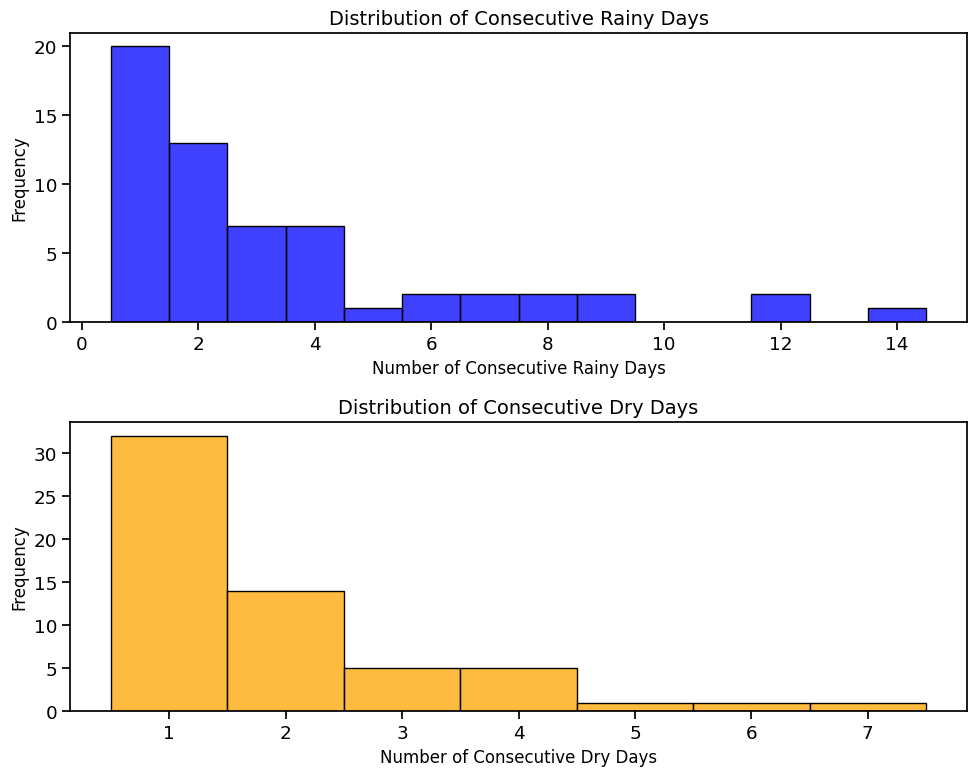

In [24]:
# Visualize streak distribution
plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
sns.histplot(rain_streaks['rain_streak_group'], bins=range(1, rain_streaks['rain_streak_group'].max()+2), 
             kde=False, color='blue', discrete=True)
plt.title('Distribution of Consecutive Rainy Days', fontsize=14)
plt.xlabel('Number of Consecutive Rainy Days', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.subplot(2, 1, 2)
sns.histplot(no_rain_streaks['rain_streak_group'], bins=range(1, no_rain_streaks['rain_streak_group'].max()+2), 
             kde=False, color='orange', discrete=True)
plt.title('Distribution of Consecutive Dry Days', fontsize=14)
plt.xlabel('Number of Consecutive Dry Days', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'rain_sequence_analysis.png'))
plt.show()

## 15. EDA Summary Report

In [25]:
# Calculate key metrics for summary
rain_frequency = df['rain_or_not'].mean() * 100
data_timespan = f"{df['date'].min().strftime('%Y-%m-%d')} to {df['date'].max().strftime('%Y-%m-%d')}"
n_observations = len(df)

# Get top correlated features
target_correlations = corr_matrix['rain_or_not'].drop('rain_or_not').sort_values(ascending=False)
top_correlations = target_correlations.head(5)

# Generate monthly rain probabilities if month column exists
monthly_stats = None
if 'month' in df.columns:
    monthly_rain = df.groupby('month')['rain_or_not'].mean()
    max_month = monthly_rain.idxmax()
    min_month = monthly_rain.idxmin()
    max_month_name = calendar.month_name[max_month]
    min_month_name = calendar.month_name[min_month]
    monthly_stats = {
        'highest': (max_month_name, monthly_rain[max_month]*100),
        'lowest': (min_month_name, monthly_rain[min_month]*100)
    }

In [26]:
# Create a summary report
print("# EDA SUMMARY REPORT")
print("\n## 1. Dataset Overview:")
print(f"- Time period: {data_timespan}")
print(f"- Total observations: {n_observations:,}")
print(f"- Rain frequency: {rain_frequency:.1f}% of days")

print("\n## 2. Top Features Correlated with Rain:")
for feature, corr in top_correlations.items():
    print(f"- {feature}: {corr:.3f}")

print("\n## 3. Top Features by Mutual Information:")
for _, row in mi_df.head(5).iterrows():
    print(f"- {row['Feature']}: {row['MI_Score']:.3f}")

if monthly_stats:
    print("\n## 4. Seasonal Patterns:")
    highest = monthly_stats['highest']
    lowest = monthly_stats['lowest']
    print(f"- Month with highest rain probability: {highest[0]} ({highest[1]:.1f}%)")
    print(f"- Month with lowest rain probability: {lowest[0]} ({lowest[1]:.1f}%)")

print("\n## 5. Statistically Significant Features:")
for feature in ['avg_temperature', 'humidity', 'avg_wind_speed']:
    rain = df[df['rain_or_not'] == 1][feature].dropna()
    no_rain = df[df['rain_or_not'] == 0][feature].dropna()
    try:
        t_stat, p_val = stats.ttest_ind(rain, no_rain, equal_var=False)
        if p_val < 0.05:
            mean_diff = rain.mean() - no_rain.mean()
            print(f"- {feature}: p={p_val:.4f}, mean diff={mean_diff:.2f}")
    except:
        print(f"- {feature}: Could not perform t-test")

# EDA SUMMARY REPORT

## 1. Dataset Overview:
- Time period: 2023-01-01 to 2023-11-07
- Total observations: 311
- Rain frequency: 63.7% of days

## 2. Top Features Correlated with Rain:
- rain_freq_3d: 0.626
- rain_freq_7d: 0.403
- humidity_rolling_3_min: 0.324
- humidity_rolling_3_mean: 0.323
- humidity: 0.321

## 3. Top Features by Mutual Information:
- rain_freq_3d: 0.238
- rain_freq_7d: 0.121
- avg_temperature_rolling_7_mean: 0.088
- avg_temperature_rolling_7_min: 0.087
- humidity_rolling_3_min: 0.077

## 4. Seasonal Patterns:
- Month with highest rain probability: January (90.3%)
- Month with lowest rain probability: November (28.6%)

## 5. Statistically Significant Features:
- avg_temperature: p=0.0000, mean diff=4.20
- humidity: p=0.0000, mean diff=12.74
- avg_wind_speed: p=0.0279, mean diff=1.16
